# Vibration data hnn

In [1]:
import math
import numpy as np
import torch, sys, io
import matplotlib.pyplot as plt
from IPython import display
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-machine'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_dataset_split, hamiltonian_fn, dynamics_fn, get_field
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, PixelHNN
from utils import integrate_model

## Set some notebook constants

In [2]:
def get_args(speed, latent_cc_pairs=1, scaled=False, folder='NORMAL', split_data=250000, scramble=False):
    return {'input_dim': 8,
         'hidden_dim': 200,
         'latent_dim': latent_cc_pairs,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 2000,
         'print_every': 200,
         'num_frames': 400,
         'name': 'machine-vibration',
         'seed': 0, 
         'save_dir': './{}/saved_models'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'scaled': scaled,
         'folder': folder,
         'speed': speed,
         'split_data': split_data,
         'scramble': scramble}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Load data

In [3]:
t_step= 1/50000

# load dataset
measurments = np.vstack((np.zeros(8).reshape(1,-1),get_measurments('NORMAL', 14.0)))
data=torch.tensor(measurments[:-1], dtype=torch.float)
next_data=torch.tensor(measurments[1:], dtype=torch.float)

measurments_dm = np.vstack((np.zeros(8).reshape(1,-1),get_dataset_clean('NORMAL', 14.0)))
data_dm=torch.tensor(measurments_dm[:-1], dtype=torch.float)
next_data_dm=torch.tensor(measurments_dm[1:], dtype=torch.float)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# getting positions and velocities
r=1

angle=np.mod(np.cumsum(measurments[:,0] * t_step / 2),1)
tv=angle*r
xv1=np.cumsum(measurments[:,1] * t_step / 2)
yv1=np.cumsum(measurments[:,2] * t_step / 2)
zv1=np.cumsum(measurments[:,3] * t_step / 2)
xv2=np.cumsum(measurments[:,4] * t_step / 2)
yv2=np.cumsum(measurments[:,5] * t_step / 2)
zv2=np.cumsum(measurments[:,6] * t_step / 2)

xq1=np.cumsum(xv1 * t_step / 2)
yq1=np.cumsum(yv1 * t_step / 2)
zq1=np.cumsum(zv1 * t_step / 2)
xq2=np.cumsum(xv2 * t_step / 2)
yq2=np.cumsum(yv2 * t_step / 2)
zq2=np.cumsum(zv2 * t_step / 2)

angle_dm=np.mod(np.cumsum(measurments_dm[:,0] * t_step / 2),1)
tv_dm=angle_dm*r
xv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,1] * t_step / 2).reshape(-1, 1))
yv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,2] * t_step / 2).reshape(-1, 1))
zv1_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,3] * t_step / 2).reshape(-1, 1))
xv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,4] * t_step / 2).reshape(-1, 1))
yv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,5] * t_step / 2).reshape(-1, 1))
zv2_dm=scaler.fit_transform(np.cumsum(measurments_dm[:,6] * t_step / 2).reshape(-1, 1))

xq1_dm=np.cumsum(xv1_dm * t_step / 2)
yq1_dm=np.cumsum(yv1_dm * t_step / 2)
zq1_dm=np.cumsum(zv1_dm * t_step / 2)
xq2_dm=np.cumsum(xv2_dm * t_step / 2)
yq2_dm=np.cumsum(yv2_dm * t_step / 2)
zq2_dm=np.cumsum(zv2_dm * t_step / 2)

xq= (xq1 + xq2) / 2
yq= (yq1 + yq2) / 2
zq= (zq1 + zq2) / 2

xv= (xv1 + xv2) / 2
yv= (yv1 + yv2) / 2
zv= (zv1 + zv2) / 2

xq_dm= (xq1_dm + xq2_dm) / 2
yq_dm= (yq1_dm + yq2_dm) / 2
zq_dm= (zq1_dm + zq2_dm) / 2

xv_dm= (xv1_dm + xv2_dm) / 2
yv_dm= (yv1_dm + yv2_dm) / 2
zv_dm= (zv1_dm + zv2_dm) / 2

total_q= ((xq ** 2) + (((measurments[:,0] * r * np.sin(angle * 2 * math.pi)) + yq) ** 2) + (((measurments[:,0] * r * np.cos(angle * 2 * math.pi)) + zq) ** 2)) ** .5
total_q_dm= ((xq_dm ** 2) + (((r * np.sin(angle_dm * 2 * math.pi)) + yq_dm) ** 2) + (((r * np.sin(angle_dm * 2 * math.pi)) + zq_dm) ** 2)) ** .5

total_v= ((xv ** 2) + (((r * np.sin(angle * 2 * math.pi)) + yv) ** 2) + (((r * np.cos(angle * 2 * math.pi)) + zv) ** 2)) ** .5
total_v_dm= ((xv_dm.reshape(1,-1)[0] ** 2) + (((measurments_dm[:,0] * r * np.sin(angle_dm * 2 * math.pi)) + yv_dm.reshape(1,-1)[0]) ** 2) + (((measurments_dm[:,0] * r * np.sin(angle_dm * 2 * math.pi)) + zv_dm.reshape(1,-1)[0]) ** 2)) ** .5

## Visualize data

In [6]:
# fig, axs = plt.subplots(2, 2, figsize=(15,15))
# axs[0, 0].scatter(angle_dm, measurments_dm[:,0])
# axs[0, 0].set_title('phase space from rotations')

# axs[0, 1].scatter(xq_dm, xv_dm, c=range(250000))
# axs[0, 1].set_title('phase space for x')

# axs[1, 0].scatter(yq_dm, xv_dm, c=range(250000))
# axs[1, 0].set_title('phase space for y')

# axs[1, 1].scatter(zq_dm, xv_dm, c=range(250000))
# axs[1, 1].set_title('phase space for z')

# for ax in axs.flat:
#     ax.set(xlabel='q', ylabel='p')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# plt.savefig('./figures/vibration-normal-phase-space.png')

## Construct models

In [3]:
def load_model(args, scaled):
    autoencoder = MLPAutoencoder(args.input_dim, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder,
                     nonlinearity=args.nonlinearity)
    fixed = '-scaled' if scaled else ''
    scramble = '-scramble' if args.scramble else ''
    partial = '-{}-datapoints'.format(args.split_data) if args.split_data != 250000 else ''
    path = "{}/machine-{}-{}-{}-pairs{}{}{}.tar".format(args.save_dir, args.folder, args.speed, args.latent_dim, fixed, partial, scramble)
    model.load_state_dict(torch.load(path))
    return model

In [4]:
def integrate_model1(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [33]:
def load_model_split(args):

    fixed = '-scaled' if args.scaled else ''
    split = '-{}-datapoints'.format(args.split_data) if args.split_data != 250000 else ''

    path_v = "{}/motor-{}-{}-{}-pair{}{}-v.tar".format(args.save_dir, args.folder, args.speed,
                                                                     args.latent_dim, fixed, split)
    autoencoder_v = MLPAutoencoder(1, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model_v = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder_v,
                     nonlinearity=args.nonlinearity)
    model_v.load_state_dict(torch.load(path_v))

    path_a1 = "{}/motor-{}-{}-{}-pair{}{}-a1.tar".format(args.save_dir, args.folder, args.speed,
                                                                args.latent_dim, fixed, split)
    autoencoder_a1 = MLPAutoencoder(3, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model_a1 = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder_a1,
                     nonlinearity=args.nonlinearity)
    model_a1.load_state_dict(torch.load(path_a1))

    path_a2 = "{}/motor-{}-{}-{}-pair{}{}-a2.tar".format(args.save_dir, args.folder, args.speed,
                                                                args.latent_dim, fixed, split)
    autoencoder_a2 = MLPAutoencoder(3, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model_a2 = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder_a2,
                     nonlinearity=args.nonlinearity)
    model_a2.load_state_dict(torch.load(path_a2))

    path_s = "{}/motor-{}-{}-{}-pair{}{}-s.tar".format(args.save_dir, args.folder, args.speed,
                                                                args.latent_dim, fixed, split)
    autoencoder_s = MLPAutoencoder(1, args.hidden_dim,
                                     args.latent_dim * 2, nonlinearity='relu')
    model_s = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder_s,
                     nonlinearity=args.nonlinearity)
    model_s.load_state_dict(torch.load(path_s))
    return model_v, model_a1, model_a2, model_s

In [34]:
args1_14 = ObjectView(get_args(14.0))
model_v, model_a1, model_a2, model_s = load_model_split(args1_14)

In [40]:
t_span = [0,100]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
v = integrate_model1(model_v, t_span, np.asarray([0., 0]), **kwargs)['y'].T
a1 = integrate_model1(model_a1, t_span, np.asarray([0., 0]), **kwargs)['y'].T
a2 = integrate_model1(model_a2, t_span, np.asarray([0., 0]), **kwargs)['y'].T
s = integrate_model1(model_s, t_span, np.asarray([0., 0]), **kwargs)['y'].T

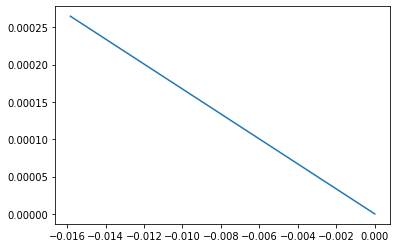

In [41]:
plt.plot(v[:,0], v[:,1])

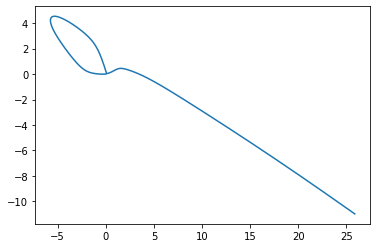

In [42]:
plt.plot(a1[:,0], a1[:,1])

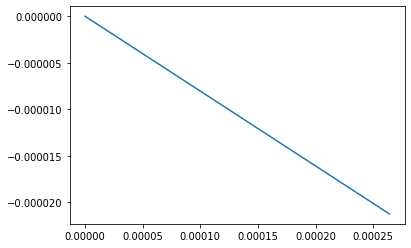

In [43]:
plt.plot(a2[:,0], a2[:,1])

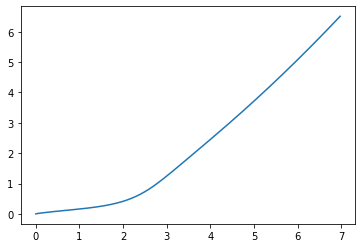

In [44]:
plt.plot(s[:,0], s[:,1])

In [111]:
t_span = [0,250]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}

#original dataset
args1_14 = ObjectView(get_args(14.0))
clean_model1_14 = load_model(args1_14, scaled=True)
noisy_model1_14 = load_model(args1_14, scaled=False)

cm114=integrate_model1(clean_model1_14, t_span, np.asarray([1., 0]), **kwargs)['y'].T
nm114=integrate_model1(noisy_model1_14, t_span, np.asarray([1., 0]), **kwargs)['y'].T

#smaller slices of dataset
args14_split200k=ObjectView(get_args(14.0,split_data=200000))
nmodel14_200k=load_model(args14_split200k, scaled=False)
cmodel14_200k=load_model(args14_split200k, scaled=True)

nm14_200k=integrate_model1(nmodel14_200k, t_span, np.asarray([1., 0]), **kwargs)['y'].T
cm14_200k=integrate_model1(cmodel14_200k, t_span, np.asarray([1., 0]), **kwargs)['y'].T

args14_split150k=ObjectView(get_args(14.0,split_data=150000))
nmodel14_150k=load_model(args14_split150k, scaled=False)
cmodel14_150k=load_model(args14_split150k, scaled=True)

nm14_150k=integrate_model1(nmodel14_150k, t_span, np.asarray([1., 0]), **kwargs)['y'].T
cm14_150k=integrate_model1(cmodel14_150k, t_span, np.asarray([1., 0]), **kwargs)['y'].T

args14_split100k=ObjectView(get_args(14.0,split_data=100000))
nmodel14_100k=load_model(args14_split100k, scaled=False)
cmodel14_100k=load_model(args14_split100k, scaled=True)

nm14_100k=integrate_model1(nmodel14_100k, t_span, np.asarray([1., 0]), **kwargs)['y'].T
cm14_100k=integrate_model1(cmodel14_100k, t_span, np.asarray([1., 0]), **kwargs)['y'].T


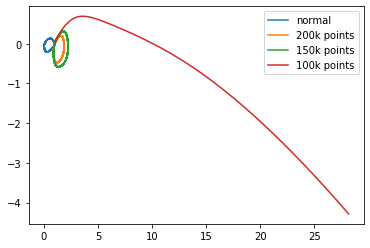

In [118]:
plt.plot(cm114336[:,0],cm114336[:,1], label='normal')
plt.plot(nm14_200k[:,0],nm14_200k[:,1], label='200k points')
plt.plot(nm14_150k[:,0],nm14_150k[:,1], label='150k points')
plt.plot(nm14_100k[:,0],nm14_100k[:,1], label='100k points')
plt.legend()
plt.show()

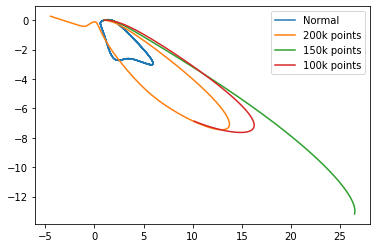

In [112]:
plt.plot(cm114[:,0],cm114[:,1], label='Normal')
plt.plot(cm14_200k[:,0],cm14_200k[:,1], label='200k points')
plt.plot(cm14_150k[:,0],cm14_150k[:,1], label='150k points')
plt.plot(cm14_100k[:,0],cm14_100k[:,1], label='100k points')
plt.legend()
plt.show()

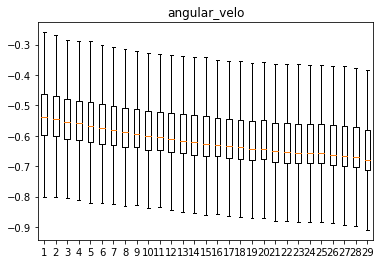

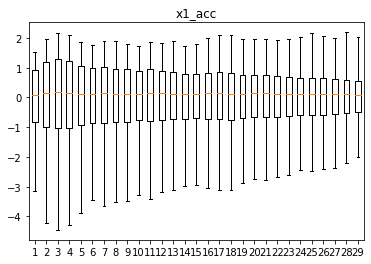

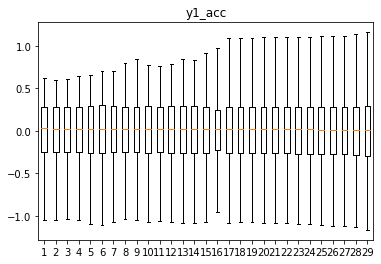

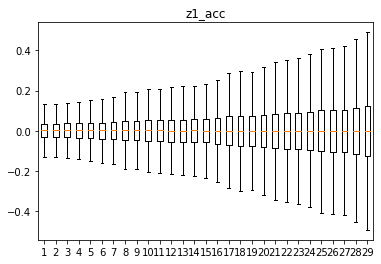

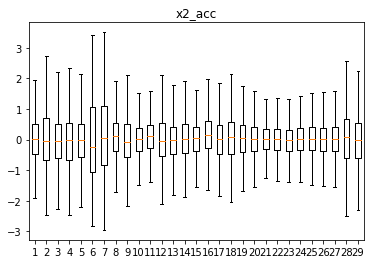

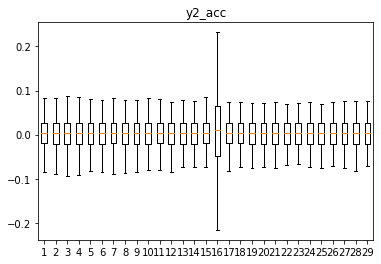

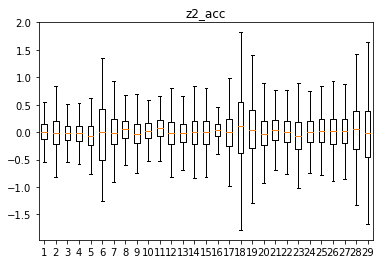

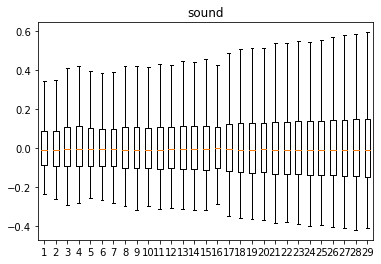

In [141]:
filenames = [12.288,13.1072,14.336,15.1552,16.1792,17.2032,18.432,19.6608,20.2752,
             21.7088,22.3232,23.552,24.576,25.6,26.624,27.4432,28.8768,29.4912,30.72,
             31.744,32.9728,33.5872,34.2016,35.4304,36.4544,37.6832,38.2976,39.3216,40.3456]

data12=get_measurments('NORMAL',12.288)
data13=get_measurments('NORMAL',13.1072)
data14=get_measurments('NORMAL',14.0)
data15=get_measurments('NORMAL',15.1552)
data16=get_measurments('NORMAL',16.1792)
data17=get_measurments('NORMAL',17.2032)
data18=get_measurments('NORMAL',18.432)
data19=get_measurments('NORMAL',19.6608)
data20=get_measurments('NORMAL',20.2752)
data21=get_measurments('NORMAL',21.7088)
data22=get_measurments('NORMAL',22.3232)
data23=get_measurments('NORMAL',23.552)
data24=get_measurments('NORMAL',24.576)
data25=get_measurments('NORMAL',25.6)
data26=get_measurments('NORMAL',26.624)
data27=get_measurments('NORMAL',27.4432)
data28=get_measurments('NORMAL',28.8768)
data29=get_measurments('NORMAL',29.4912)
data30=get_measurments('NORMAL',30.72)
data31=get_measurments('NORMAL',31.744)
data32=get_measurments('NORMAL',32.9728)
data33=get_measurments('NORMAL',33.5872)
data34=get_measurments('NORMAL',34.2016)
data35=get_measurments('NORMAL',35.4304)
data36=get_measurments('NORMAL',36.4544)
data37=get_measurments('NORMAL',37.6832)
data38=get_measurments('NORMAL',38.2976)
data39=get_measurments('NORMAL',39.3216)
data40=get_measurments('NORMAL',40.3456)

column_name=['angular_velo', 'x1_acc', 'y1_acc', 'z1_acc', 'x2_acc', 'y2_acc', 'z2_acc', 'sound']
dataset = [data12, data13, data14, data15, data16, data17, data18, data19, data20,
           data21, data22, data23, data24, data25, data26, data27, data28, data29, data30,
           data31, data32, data33, data34, data35, data36, data37, data38, data39, data40]

for i in range(8):
    data=[]
    for file in dataset:
        data.append(file[:,i])
    plt.boxplot(data, showfliers=False)
    plt.title(column_name[i])
    plt.show()
    plt.close()

## Loading models of diff speeds

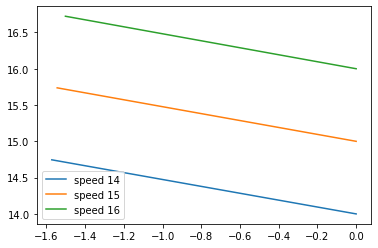

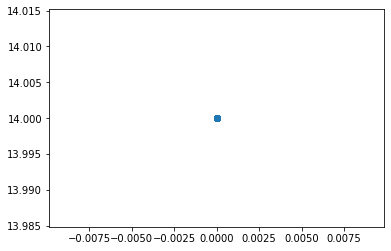

In [72]:
model_all_big, model_all_small =load_model_all(ObjectView(get_args(14.0)))

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}

all_int_s=integrate_model1(model_all_small, t_span, np.asarray([0., 14]), **kwargs)['y'].T
plt.plot(all_int_s[:,0], all_int_s[:,1], label='speed 14')
all_int_s=integrate_model1(model_all_small, t_span, np.asarray([0., 15]), **kwargs)['y'].T
plt.plot(all_int_s[:,0], all_int_s[:,1], label='speed 15')
all_int_s=integrate_model1(model_all_small, t_span, np.asarray([0., 16]), **kwargs)['y'].T
plt.plot(all_int_s[:,0], all_int_s[:,1], label='speed 16')
plt.legend()
plt.show()

all_int_b=integrate_model1(model_all_big, t_span, np.asarray([0., 14]), **kwargs)['y'].T
plt.scatter(all_int_b[:,0], all_int_b[:,1])
plt.show()

In [62]:
torch.manual_seed(0)
a=torch.randn(1,8)
e=model_all_big.encode(a)
t=e + model_all_big.time_derivative(e)
d=model_all_big.decode(t)
f=model_all_big.forward(a)
print('8 inputs: ', a.detach().numpy()[0])
print('encoded phase space: ', e.detach().numpy()[0])
print('time evolution in p.s.: ', t.detach().numpy()[0])
print('decoded: ', d.detach().numpy()[0])


8 inputs:  [ 1.5409961  -0.2934289  -2.1787894   0.56843126 -1.0845224  -1.3985955
  0.40334684  0.83802634]
encoded phase space:  [0.03925919 0.00534393]
time evolution in p.s.:  [0.03925919 0.00534393]
decoded:  [ 0.5998193   0.64274395 -0.36881784  0.15982038  0.6038487   0.25759864
  0.35664043  0.16472825]


In [ ]:
#loading and integrating models
p=14.0
args1_14 = ObjectView(get_args(p))
clean_model1_14 = load_model(args1_14, scaled=True)
noisy_model1_14 = load_model(args1_14, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}

nm114=integrate_model1(noisy_model1_14, t_span, np.asarray([0., p]), **kwargs)['y'].T
cm114=integrate_model1(clean_model1_14, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=12.288
args1_12288 = ObjectView(get_args(p))
clean_model1_12288 = load_model(args1_12288, scaled=True)
noisy_model1_12288 = load_model(args1_12288, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm12288 = integrate_model1(clean_model1_12288, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm12288 = integrate_model1(noisy_model1_12288, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [88]:
p=13.1072
args1_131072 = ObjectView(get_args(p))
clean_model1_131072 = load_model(args1_131072, scaled=True)
noisy_model1_131072 = load_model(args1_131072, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm131072 = integrate_model1(clean_model1_131072, t_span, np.asarray([1., 0]), **kwargs)['y'].T
nm131072 = integrate_model1(noisy_model1_131072, t_span, np.asarray([1., 0]), **kwargs)['y'].T

In [89]:
p=14.336
args1_14336 = ObjectView(get_args(p))
clean_model1_14336 = load_model(args1_14336, scaled=True)
noisy_model1_14336 = load_model(args1_14336, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm114336=integrate_model1(noisy_model1_14336, t_span, np.asarray([1., 0]), **kwargs)['y'].T
cm114336=integrate_model1(clean_model1_14336, t_span, np.asarray([1., 0]), **kwargs)['y'].T

In [90]:
p=15.1552
args1_151552 = ObjectView(get_args(p))
clean_model1_151552 = load_model(args1_151552, scaled=True)
noisy_model1_151552 = load_model(args1_151552, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm151552 = integrate_model1(clean_model1_151552, t_span, np.asarray([1., 0]), **kwargs)['y'].T
nm151552 = integrate_model1(noisy_model1_151552, t_span, np.asarray([1., 0]), **kwargs)['y'].T

In [92]:
p=16.1792
args1_161792 = ObjectView(get_args(p))
clean_model1_161792 = load_model(args1_161792, scaled=True)
noisy_model1_161792 = load_model(args1_161792, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm161792 = integrate_model1(clean_model1_161792, t_span, np.asarray([1., 0]), **kwargs)['y'].T
nm161792 = integrate_model1(noisy_model1_161792, t_span, np.asarray([1., 0]), **kwargs)['y'].T

In [ ]:
p=17.2032
args1_172032 = ObjectView(get_args(p))
clean_model1_172032 = load_model(args1_172032, scaled=True)
noisy_model1_172032 = load_model(args1_172032, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm172032 = integrate_model1(clean_model1_172032, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm172032 = integrate_model1(noisy_model1_172032, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=18.432
args1_18432 = ObjectView(get_args(p))
clean_model1_18432 = load_model(args1_18432, scaled=True)
noisy_model1_18432 = load_model(args1_18432, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm18432 = integrate_model1(clean_model1_18432, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm18432 = integrate_model1(noisy_model1_18432, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=19.6608
args1_196608 = ObjectView(get_args(p))
clean_model1_196608 = load_model(args1_196608, scaled=True)
noisy_model1_196608 = load_model(args1_196608, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm196608 = integrate_model1(clean_model1_196608, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm196608 = integrate_model1(noisy_model1_196608, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=20.2752
args1_202752 = ObjectView(get_args(p))
clean_model1_202752 = load_model(args1_202752, scaled=True)
noisy_model1_202752 = load_model(args1_202752, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm202752 = integrate_model1(clean_model1_202752, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm202752 = integrate_model1(noisy_model1_202752, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=21.7088
args1_217088 = ObjectView(get_args(p))
clean_model1_217088 = load_model(args1_217088, scaled=True)
noisy_model1_217088 = load_model(args1_217088, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm217088 = integrate_model1(clean_model1_217088, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm217088 = integrate_model1(noisy_model1_217088, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=22.3232
args1_223232 = ObjectView(get_args(p))
clean_model1_223232 = load_model(args1_223232, scaled=True)
noisy_model1_223232 = load_model(args1_223232, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm223232 = integrate_model1(clean_model1_223232, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm223232 = integrate_model1(noisy_model1_223232, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=24.576
args1_24576 = ObjectView(get_args(p))
clean_model1_24576 = load_model(args1_24576, scaled=True)
noisy_model1_24576 = load_model(args1_24576, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm24576 = integrate_model1(clean_model1_24576, t_span, np.asarray([0., p]), **kwargs)['y'].T
nm24576 = integrate_model1(noisy_model1_24576, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [93]:
p=25.6
args1_256 = ObjectView(get_args(p))
clean_model1_256 = load_model(args1_256, scaled=True)
noisy_model1_256 = load_model(args1_256, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
cm256 = integrate_model1(clean_model1_256, t_span, np.asarray([1., 0]), **kwargs)['y'].T
nm256 = integrate_model1(noisy_model1_256, t_span, np.asarray([1., 0]), **kwargs)['y'].T

In [ ]:
p=41.7792
args1_417792 = ObjectView(get_args(p))
noisy_model1_417792 = load_model(args1_417792, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm417792 = integrate_model1(noisy_model1_417792, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=46.2848
args1_462848 = ObjectView(get_args(p))
noisy_model1_462848 = load_model(args1_462848, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm462848 = integrate_model1(noisy_model1_462848, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=51.8144
args1_518144 = ObjectView(get_args(p))
noisy_model1_518144 = load_model(args1_518144, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm518144 = integrate_model1(noisy_model1_518144, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=56.7296
args1_567296 = ObjectView(get_args(p))
noisy_model1_567296 = load_model(args1_567296, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm567296 = integrate_model1(noisy_model1_567296, t_span, np.asarray([0., p]), **kwargs)['y'].T

In [ ]:
p=61.44
args1_6144 = ObjectView(get_args(p))
noisy_model1_6144 = load_model(args1_6144, scaled=False)

t_span = [0,1000]
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_span[1] * 10), 'rtol': 1e-12}
nm6144 = integrate_model1(noisy_model1_6144, t_span, np.asarray([0., p]), **kwargs)['y'].T

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


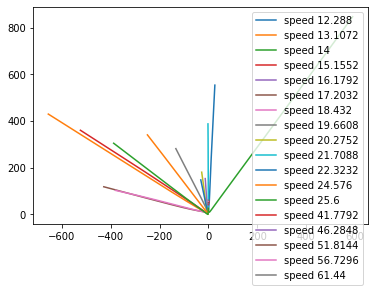

In [117]:
plt.plot(nm12288[:,0],nm12288[:,1], label='speed 12.288')
plt.plot(nm131072[:,0],nm131072[:,1], label='speed 13.1072')
plt.plot(nm114[:,0],nm114[:,1], label='speed 14')
plt.plot(nm151552[:,0],nm151552[:,1], label='speed 15.1552')
plt.plot(nm161792[:,0],nm161792[:,1], label='speed 16.1792')
plt.plot(nm172032[:,0],nm172032[:,1], label='speed 17.2032')
plt.plot(nm18432[:,0],nm18432[:,1], label='speed 18.432')
plt.plot(nm196608[:,0],nm196608[:,1], label='speed 19.6608')
plt.plot(nm202752[:,0],nm202752[:,1], label='speed 20.2752')
plt.plot(nm217088[:,0],nm217088[:,1], label='speed 21.7088')
plt.plot(nm223232[:,0],nm223232[:,1], label='speed 22.3232')
plt.plot(nm24576[:,0],nm24576[:,1], label='speed 24.576')
plt.plot(nm256[:,0],nm256[:,1], label='speed 25.6')
plt.plot(nm417792[:,0],nm417792[:,1], label='speed 41.7792')
plt.plot(nm462848[:,0],nm462848[:,1], label='speed 46.2848')
plt.plot(nm518144[:,0],nm518144[:,1], label='speed 51.8144')
plt.plot(nm567296[:,0],nm567296[:,1], label='speed 56.7296')
plt.plot(nm6144[:,0],nm6144[:,1], label='speed 61.44')
plt.legend()
plt.show()

C:\Users\jerem\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


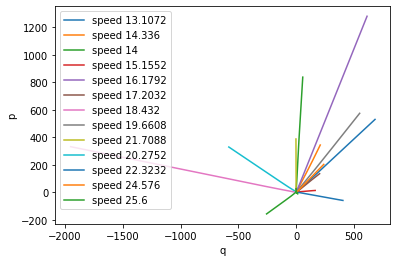

In [115]:
plt.plot(cm131072[:,0],cm131072[:,1], label='speed 13.1072')
plt.plot(cm114336[:,0],cm114336[:,1], label='speed 14.336')
plt.plot(cm114[:,0],cm114[:,1], label='speed 14')
plt.plot(cm151552[:,0],cm151552[:,1], label='speed 15.1552')
plt.plot(cm161792[:,0],cm161792[:,1], label='speed 16.1792')
plt.plot(cm172032[:,0],cm172032[:,1], label='speed 17.2032')
plt.plot(cm18432[:,0],cm18432[:,1], label='speed 18.432')
plt.plot(cm196608[:,0],cm196608[:,1], label='speed 19.6608')
plt.plot(cm217088[:,0],cm217088[:,1], label='speed 21.7088')
plt.plot(cm202752[:,0],cm202752[:,1], label='speed 20.2752')
plt.plot(cm223232[:,0],cm223232[:,1], label='speed 22.3232')
plt.plot(cm24576[:,0],cm24576[:,1], label='speed 24.576')
plt.plot(cm256[:,0],cm256[:,1], label='speed 25.6')
plt.xlabel('q')
plt.ylabel('p')
plt.legend()
plt.show()

In [132]:
h14=np.sum(hamiltonian_fn(nm518144), axis = 1, keepdims = True)

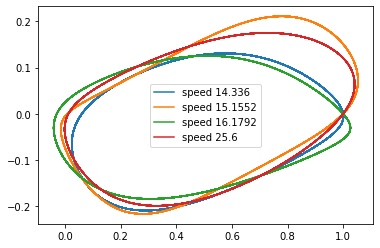

In [116]:
# plt.plot(nm131072[:,0],nm131072[:,1], label='speed 13.1072')
plt.plot(cm114336[:,0],cm114336[:,1], label='speed 14.336')
plt.plot(nm151552[:,0],nm151552[:,1], label='speed 15.1552')
plt.plot(nm161792[:,0],nm161792[:,1], label='speed 16.1792')
plt.plot(nm256[:,0],nm256[:,1], label='speed 25.6')
plt.legend()
plt.show()

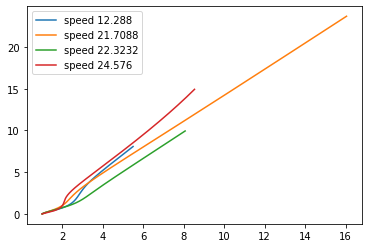

In [49]:
plt.plot(nm12288[:,0],nm12288[:,1], label='speed 12.288')
plt.plot(nm217088[:,0],nm217088[:,1], label='speed 21.7088')
plt.plot(nm223232[:,0],nm223232[:,1], label='speed 22.3232')
plt.plot(nm24576[:,0],nm24576[:,1], label='speed 24.576')
plt.legend()
plt.show()

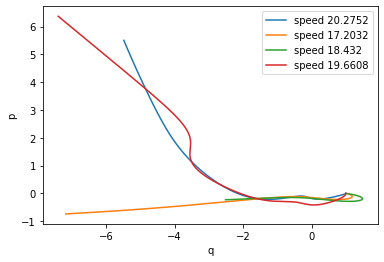

In [50]:
plt.plot(nm202752[:,0],nm202752[:,1], label='speed 20.2752')
plt.plot(nm172032[:,0],nm172032[:,1], label='speed 17.2032')
plt.plot(nm18432[:,0],nm18432[:,1], label='speed 18.432')
plt.plot(nm196608[:,0],nm196608[:,1], label='speed 19.6608')
plt.xlabel('q')
plt.ylabel('p')
plt.legend()
plt.show()

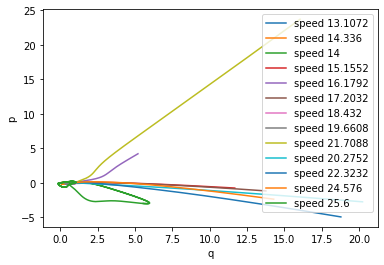

In [59]:
plt.plot(cm131072[:,0],cm131072[:,1], label='speed 13.1072')
plt.plot(cm114336[:,0],cm114336[:,1], label='speed 14.336')
plt.plot(cm114[:,0],cm114[:,1], label='speed 14')
plt.plot(cm151552[:,0],cm151552[:,1], label='speed 15.1552')
plt.plot(cm161792[:,0],cm161792[:,1], label='speed 16.1792')
plt.plot(cm172032[:,0],cm172032[:,1], label='speed 17.2032')
plt.plot(cm18432[:,0],cm18432[:,1], label='speed 18.432')
plt.plot(cm196608[:,0],cm196608[:,1], label='speed 19.6608')
plt.plot(cm217088[:,0],cm217088[:,1], label='speed 21.7088')
plt.plot(cm202752[:,0],cm202752[:,1], label='speed 20.2752')
plt.plot(cm223232[:,0],cm223232[:,1], label='speed 22.3232')
plt.plot(cm24576[:,0],cm24576[:,1], label='speed 24.576')
plt.plot(cm256[:,0],cm256[:,1], label='speed 25.6')
plt.xlabel('q')
plt.ylabel('p')
plt.legend()
plt.show()